In [1]:
# import all libraries
import itertools, cv2, os, time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import plot_confusion_matrix

from glob import glob

In [2]:
# set data directories
train_dir = os.path.join('lung_image_sets')

# lung adenocarcinoma path
lung_aca = os.path.join('lung_image_sets/lung_aca')

# lung benign path
lung_n = os.path.join('lung_image_sets/lung_n')

# lung squamos cell carcinoma path
lung_scc = os.path.join('lung_image_sets/lung_scc')

In [3]:
%%time
train_aca_names = os.listdir(lung_aca)
print(f'TRAIN SET ADENOCARCINOMA: {train_aca_names[:10]}')
print('\n')

train_n_names = os.listdir(lung_n)
print(f'TRAIN SET BENIGN: {train_n_names[:10]}')
print('\n')

train_scc_names = os.listdir(lung_scc)
print(f'TRAIN SET SQUAMOS CELL CARCINOMA: {train_scc_names[:10]}')

TRAIN SET ADENOCARCINOMA: ['lungaca2056.jpeg', 'lungaca1914.jpeg', 'lungaca3989.jpeg', 'lungaca3803.jpeg', 'lungaca861.jpeg', 'lungaca4231.jpeg', 'lungaca4646.jpeg', 'lungaca4483.jpeg', 'lungaca918.jpeg', 'lungaca452.jpeg']


TRAIN SET BENIGN: ['lungn691.jpeg', 'lungn3098.jpeg', 'lungn4225.jpeg', 'lungn40.jpeg', 'lungn4213.jpeg', 'lungn4645.jpeg', 'lungn3468.jpeg', 'lungn3880.jpeg', 'lungn1406.jpeg', 'lungn3177.jpeg']


TRAIN SET SQUAMOS CELL CARCINOMA: ['lungscc1930.jpeg', 'lungscc1441.jpeg', 'lungscc4624.jpeg', 'lungscc4038.jpeg', 'lungscc2504.jpeg', 'lungscc1129.jpeg', 'lungscc3862.jpeg', 'lungscc1153.jpeg', 'lungscc1918.jpeg', 'lungscc3360.jpeg']
CPU times: user 7.18 ms, sys: 11.3 ms, total: 18.4 ms
Wall time: 835 ms


In [4]:
print(f'total training Adenocarcinoma images: {len(os.listdir(lung_aca))}')
print(f'total training Benign images: {len(os.listdir(lung_n))}')
print(f'total training Squamous Cell Carcinoma images: {len(os.listdir(lung_scc))}')

# calculate number of training images
train_aca = len(os.listdir(lung_aca))
train_n = len(os.listdir(lung_n))
train_scc = len(os.listdir(lung_scc))
total = train_aca + train_n + train_scc

# print total number of images
print('Total Images in dataset: %s' % str((total))) 


total training Adenocarcinoma images: 5000
total training Benign images: 5000
total training Squamous Cell Carcinoma images: 5000
Total Images in dataset: 15000


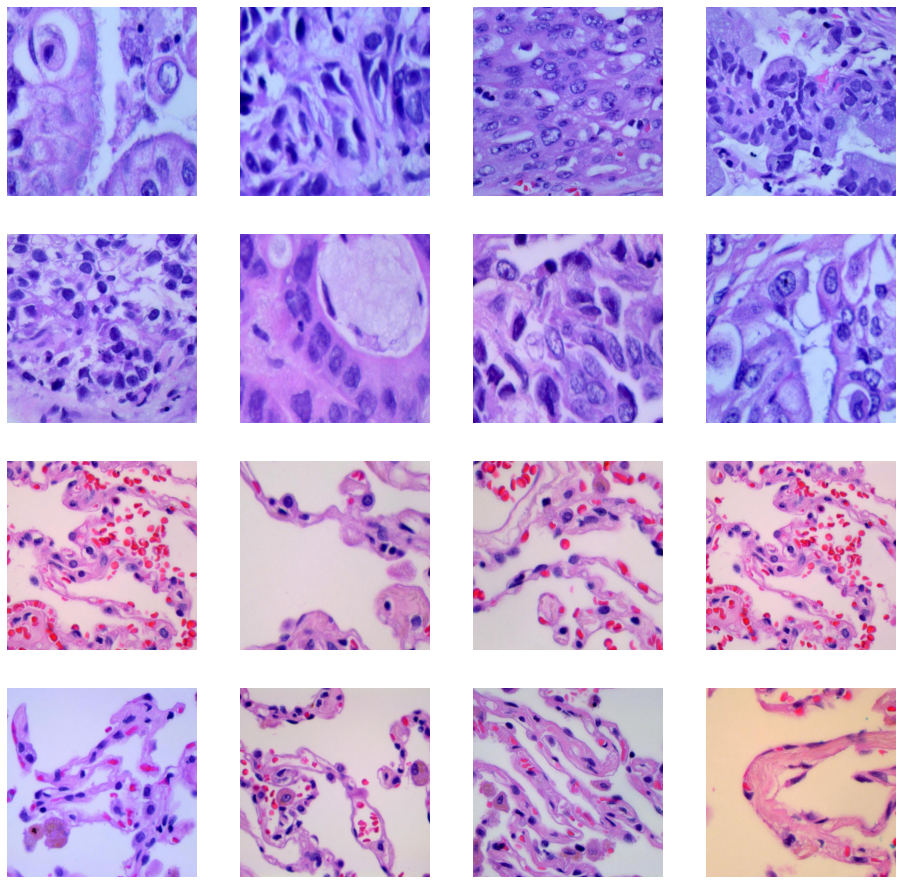

In [6]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_aca_pix = [os.path.join(lung_aca, fname) 
                for fname in train_aca_names[pic_index-8:pic_index]]

next_n_pix = [os.path.join(lung_n, fname) 
                for fname in train_n_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_aca_pix + next_n_pix):
    
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

In [7]:
%%time

data_dir = 'lung_image_sets/'

# making a data split of 80-20
data = ImageDataGenerator(validation_split = 0.2)

# setting up the batch size
BATCH_SIZE = 128

# setting up the image size
X = Y = 224

# making training dataset
train_data = data.flow_from_directory(data_dir,
                                    class_mode = "categorical",
                                    target_size = (X, Y),
                                    color_mode="rgb",
                                    batch_size = BATCH_SIZE, 
                                    shuffle = False,
                                    subset='training',
                                    seed = 42)

# making validation dataset
val_data = data.flow_from_directory(data_dir,
                                      class_mode = "categorical",
                                      target_size = (X, Y),
                                      color_mode="rgb",
                                      batch_size = BATCH_SIZE, 
                                      shuffle = False,
                                      subset='validation',
                                      seed = 42)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
CPU times: user 657 ms, sys: 364 ms, total: 1.02 s
Wall time: 17 s


In [8]:
# print label names
label =  {0: "lung adenocarcinoma", 1: "benign", 2: "squamous cell carcinoma"}
for t in label.keys():
    print(t, label[t])

0 lung adenocarcinoma
1 benign
2 squamous cell carcinoma


In [9]:
# initializing efficientnet b7 cnn model
eff_7 = EfficientNetB7 (
        input_shape=(X, Y, 3),
        weights='imagenet',
        include_top=False
        )

# setting trainable to false    
eff_7.trainable = False

# global avg pooling layer
x = GlobalAveragePooling2D()(eff_7.output)
# flatten layer
x = Flatten()(x)
# fully connected layer 1
x = Dense(128, activation='relu')(x)
# fully connected layer 2
x = Dense(64, activation='relu')(x)

# outout layer
y = Dense(3, activation='softmax')(x) # since we have three outputs, we will use 3 neurons in last layer

# setting up y = f(x)
# tie it together
model = Model(inputs=eff_7.input, 
              outputs=y)

2023-02-13 00:40:39.999855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 00:40:40.000797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 00:40:40.118414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 00:40:40.119208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-13 00:40:40.119969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

258088960/258076736 [==============================] - 1s 0us/step


In [10]:
# compiling the model
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [12]:
# for accuracy
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('val_accuracy') >= 0.973:
                print('\nReached 97.3% accuracy so cancelling training!')
                self.model.stop_training=True
                
callbacks = myCallback()

In [13]:
# setting up early stopping to stop training when max acc is reached
# we are using validation loss as parameter for monitoring the training process

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3)

logger = CSVLogger('logs.csv', append=True)

In [14]:
# fitting the model to training data
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[callbacks, logger]
)

2023-02-13 00:44:49.632745: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-02-13 00:45:09.894124: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


94/94 [==============================] - 308s 3s/step - loss: 0.4814 - accuracy: 0.8281 - val_loss: 0.4126 - val_accuracy: 0.8140
Epoch 2/10
94/94 [==============================] - 211s 2s/step - loss: 0.2229 - accuracy: 0.9135 - val_loss: 0.1476 - val_accuracy: 0.9407
Epoch 3/10
94/94 [==============================] - 211s 2s/step - loss: 0.1688 - accuracy: 0.9347 - val_loss: 0.1254 - val_accuracy: 0.9553
Epoch 4/10
94/94 [==============================] - 213s 2s/step - loss: 0.1395 - accuracy: 0.9463 - val_loss: 0.1011 - val_accuracy: 0.9607
Epoch 5/10
94/94 [==============================] - 211s 2s/step - loss: 0.1251 - accuracy: 0.9517 - val_loss: 0.1133 - val_accuracy: 0.9567
Epoch 6/10
94/94 [==============================] - 211s 2s/step - loss: 0.1102 - accuracy: 0.9594 - val_loss: 0.0930 - val_accuracy: 0.9627
Epoch 7/10
94/94 [==============================] - 213s 2s/step - loss: 0.1098 - accuracy: 0.9566 - val_loss: 0.1421 - val_accuracy: 0.9373
Epoch 8/10
94/94 [======

**Visualize Model Predictions**

In [15]:
# calculate model history
hist = history.history
hist.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

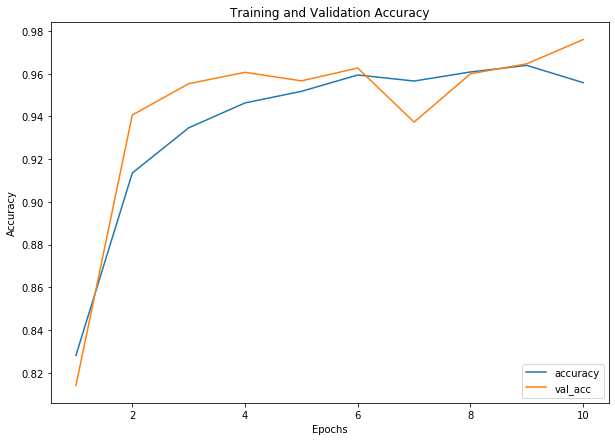

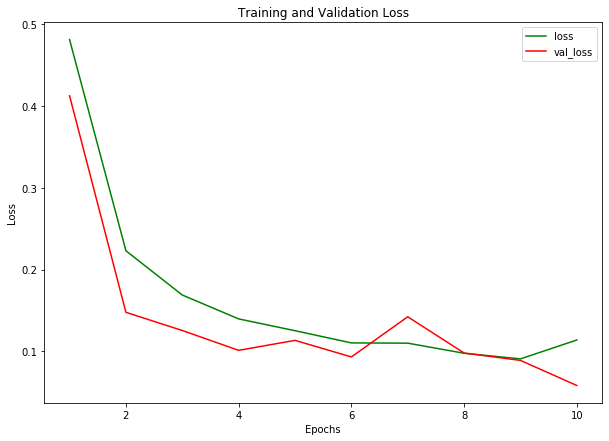

In [16]:
plt.style.use('_classic_test_patch')

epochs = range(1, len(hist['loss']) + 1)
acc = hist['accuracy']
loss = hist['loss']
val_acc = hist['val_accuracy']
val_loss = hist['val_loss']

# plot loss versus accuracy
plt.figure(figsize=(10, 7))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend(loc='lower right')

# plot validation versus accuract
plt.figure(figsize=(10, 7))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()

In [17]:
# calculate result of validation data
scores = model.evaluate(val_data)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

24/24 [==============================] - 43s 2s/step - loss: 0.0580 - accuracy: 0.9760
accuracy: 97.60%


**Classification Report**

In [18]:
y_hat = model.predict(val_data)
y_pred = np.argmax(y_hat, axis=1)

# print classification report
print(classification_report(val_data.classes, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1000
           1       1.00      1.00      1.00      1000
           2       0.97      0.96      0.97      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



Normalized confusion matrix


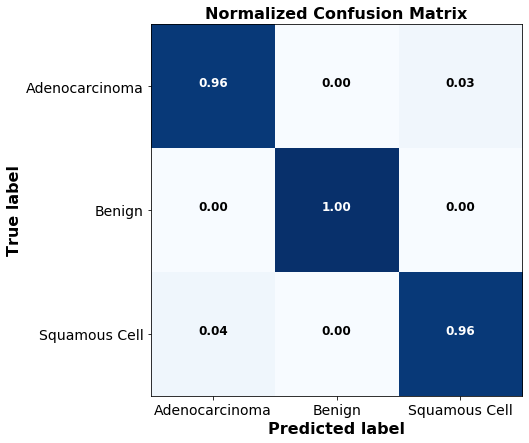

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

# computing confusion matrix
cnf_matrix = confusion_matrix(val_data.classes, y_pred)
np.set_printoptions(precision=2)

# plotting non-normalized confusion matrix
plt.figure(figsize=(10, 6))
plot_confusion_matrix(cnf_matrix, classes=['Adenocarcinoma', 'Benign', 'Squamous Cell'],
                      normalize=True,
                      title='Normalized Confusion Matrix')
plt.show()

In [20]:
from keras.preprocessing import image
path = 'lung_image_sets/lung_n/lungn1002.jpeg'
my_image = mpimg.imread(path)
img = image.load_img(path, target_size=(224, 224))

In [21]:
img = image.img_to_array(img)
x = np.expand_dims(img, axis=0)
x.shape

(1, 224, 224, 3)

[1]
benign


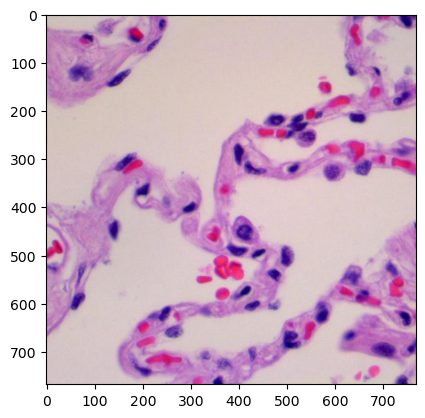

In [22]:
classes = np.argmax(model.predict(x), axis=1)
print(classes)
print(label[classes[0]])
plt.style.use('default')
plt.imshow(my_image)